<a href="https://colab.research.google.com/github/reihanedva/CS-SBU-NeuralNetwork_MSc2021-projects/blob/main/ReihaneDavarzani-99422079/project3/NN3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
from importlib import reload
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imread_collection, concatenate_images
from sklearn.utils import shuffle
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

import time
import os
import sys
import random
import warnings
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from datetime import datetime 
import glob 

In [ ]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"reihanedavarzani","key":"90e5ce765158c2658fcf1d7f2e76bf11"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d thedownhill/art-images-drawings-painting-sculpture-engraving

100% 581M/583M [00:11<00:00, 77.2MB/s]
100% 583M/583M [00:11<00:00, 55.2MB/s]


In [ ]:
!ls

art-images-drawings-painting-sculpture-engraving.zip  kaggle.json  sample_data


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('art-images-drawings-painting-sculpture-engraving.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [ ]:
!ls

art-images-drawings-painting-sculpture-engraving.zip  kaggle.json
files						      sample_data


In [6]:
from os import listdir, remove
images = listdir('/content/files/dataset/dataset_updated/training_set/painting')
imageValue = listdir('/content/files/dataset/dataset_updated/validation_set/painting/')


In [7]:
for image in enumerate(images):
    try:
        Image.open('/content/files/dataset/dataset_updated/training_set/painting/'+image[1])  
    except OSError:
        os.remove('/content/files/dataset/dataset_updated/training_set/painting/'+image[1])

In [8]:
for image in enumerate(imageValue):
    try:
        Image.open('/content/files/dataset/dataset_updated/validation_set/painting/'+image[1])  
    except OSError:
        os.remove('/content/files/dataset/dataset_updated/validation_set/painting/'+image[1])

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {device}!')        

Running on cpu!


In [27]:
lab_version = 1 #tanh

In [58]:
# data loaders
BATCH_SIZE = 32 
IMG_SIZE = 32

# model
save_images = True
epochs = 100
print_every = 1
save_every = 20

# make output folders
OUTPUT_PATH = f'v0_lab{lab_version}_outputs'
CHECKPOINTS_PATH = f'v0_lab{lab_version}_checkpoints'

os.makedirs(f'{OUTPUT_PATH}/color', exist_ok=True)
os.makedirs(f'{OUTPUT_PATH}/gray', exist_ok=True)
os.makedirs(f'{CHECKPOINTS_PATH}', exist_ok=True)

In [29]:
# define transformations
train_transforms = transforms.Compose([
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5)
])

valid_transforms = transforms.Compose([
    transforms.CenterCrop((IMG_SIZE, IMG_SIZE))
])

# image folders
train_folder = ColorizationImageFolder(root='/content/files/dataset/dataset_updated/training_set/imgT', 
                                       lab_version=lab_version, 
                                       transform=train_transforms)
valid_folder = ColorizationImageFolder(root='/content/files/dataset/dataset_updated/validation_set/imgV', 
                                       lab_version=lab_version, 
                                       transform=valid_transforms)

# image loaders 
train_loader = torch.utils.data.DataLoader(train_folder, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_folder, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=False)


# ***`base model`***

In [30]:
class ColorCNN_v0(nn.Module):
    def __init__(self, lab_version):
        super(ColorCNN_v0, self).__init__()

        self.relu = nn.ReLU()
        
        if lab_version == 1:
            self.final = nn.Tanh()
        elif lab_version == 2:
            self.final = nn.Sigmoid()
        
        self.upsampling = Upsample(scale_factor=2, mode='nearest')
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=2, padding=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), stride=2, padding=1, bias=True)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=2, padding=1, bias=True)
        
        self.conv7 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv8 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv9 = nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(3,3), stride=1, padding=1, bias=True)

        self.color = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.upsampling,
            self.conv7,
            self.relu,
            self.upsampling,
            self.conv8,
            self.relu,
            self.upsampling,
            self.conv9,
            self.final
        )
    
    def forward(self, x):
        return self.color(x)
    

In [ ]:
model = ColorCNN_v0(lab_version=lab_version).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

In [ ]:
model

ColorCNN_v0(
  (relu): ReLU()
  (final): Tanh()
  (upsampling): Upsample()
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (color): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(8, 16, kernel_size=(3

14:55:39 --- Epoch: 0	Train loss: 0.0058	Valid loss: 0.0076	Epoch time: 9.89 (avg. 9.89)
14:55:49 --- Epoch: 1	Train loss: 0.0051	Valid loss: 0.0078	Epoch time: 9.73 (avg. 9.81)
14:55:58 --- Epoch: 2	Train loss: 0.0051	Valid loss: 0.0072	Epoch time: 9.63 (avg. 9.75)
14:56:08 --- Epoch: 3	Train loss: 0.0051	Valid loss: 0.0074	Epoch time: 9.76 (avg. 9.75)
14:56:18 --- Epoch: 4	Train loss: 0.0051	Valid loss: 0.0074	Epoch time: 9.58 (avg. 9.72)
14:56:27 --- Epoch: 5	Train loss: 0.0050	Valid loss: 0.0071	Epoch time: 9.58 (avg. 9.69)
14:56:37 --- Epoch: 6	Train loss: 0.0049	Valid loss: 0.0073	Epoch time: 9.57 (avg. 9.68)
14:56:47 --- Epoch: 7	Train loss: 0.0051	Valid loss: 0.0071	Epoch time: 9.63 (avg. 9.67)
14:56:56 --- Epoch: 8	Train loss: 0.0046	Valid loss: 0.0073	Epoch time: 9.67 (avg. 9.67)
14:57:06 --- Epoch: 9	Train loss: 0.0048	Valid loss: 0.0072	Epoch time: 9.62 (avg. 9.67)
14:57:15 --- Epoch: 10	Train loss: 0.0049	Valid loss: 0.0076	Epoch time: 9.64 (avg. 9.66)
14:57:25 --- Epoch: 

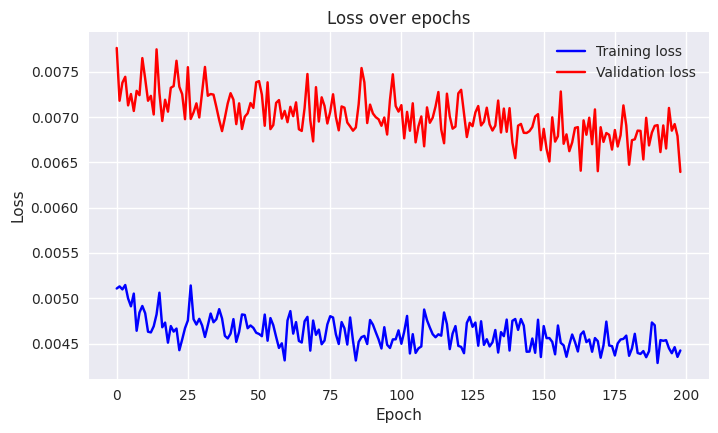

In [ ]:
model, optimizer, losses = training_loop(model, criterion, optimizer, train_loader, 
                                          valid_loader, epochs, device, 
                                          save_dir=CHECKPOINTS_PATH, 
                                          save_every=save_every, 
                                          print_every=print_every)

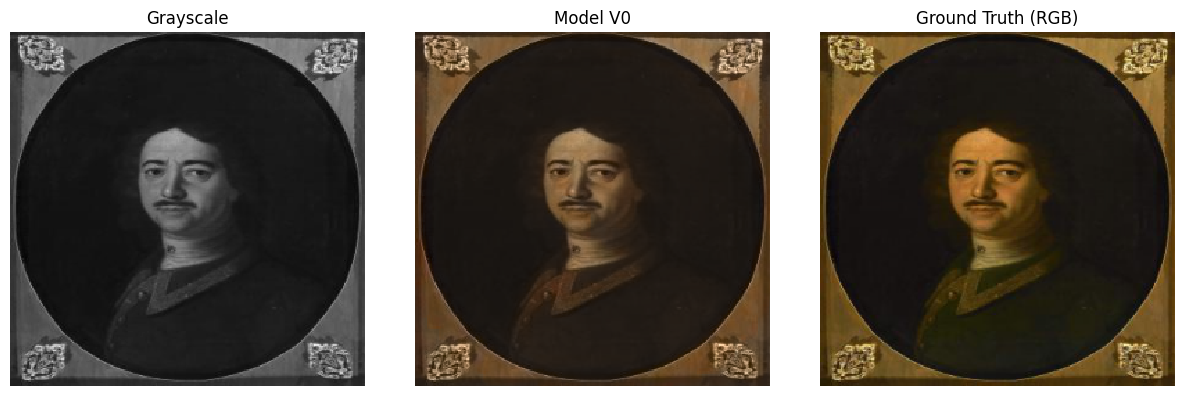

In [ ]:
show_model_results(model, 
                   model_name='Model V0', 
                   lab_version=lab_version, 
                   path=get_random_file('/content/files/dataset/dataset_updated/training_set/imgT/painting', 'jpg'), 
                   img_size=256, 
                   device=device)

# ***`deep model`***

In [55]:
class ColorCNN_v1(nn.Module):
    def __init__(self, lab_version):
        super(ColorCNN_v1, self).__init__()

        self.relu = nn.ReLU()
        
        if lab_version == 1:
            self.final = nn.Tanh()
        elif lab_version == 2:
            self.final = nn.Sigmoid()
        
        self.upsampling = Upsample(scale_factor=2, mode='nearest')
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=2, padding=1, bias=True)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=2, padding=1, bias=True)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=2, padding=1, bias=True)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv8 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv9 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv10 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv11 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv12 = nn.Conv2d(in_channels=32, out_channels=2, kernel_size=(3,3), stride=1, padding=1, bias=True)

        self.color = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.conv7,
            self.relu,
            self.conv8,
            self.relu,
            self.conv9,
            self.relu,
            self.upsampling,
            self.conv10,
            self.relu,
            self.upsampling,
            self.conv11,
            self.relu,
            self.conv12,
            self.final,
            self.upsampling
        )
    
    def forward(self, x):
        return self.color(x)

In [ ]:
model = ColorCNN_v1(lab_version=lab_version).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)


In [ ]:
model

ColorCNN_v1(
  (relu): ReLU()
  (final): Tanh()
  (upsampling): Upsample()
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(32, 2, kernel_size=(3, 3), stride=(1, 1), pa

06:11:45 --- Epoch: 0	Train loss: 0.0046	Valid loss: 0.0067	Epoch time: 53.51 (avg. 53.51)
06:12:39 --- Epoch: 1	Train loss: 0.0047	Valid loss: 0.0069	Epoch time: 53.55 (avg. 53.53)
06:13:33 --- Epoch: 2	Train loss: 0.0046	Valid loss: 0.0070	Epoch time: 53.91 (avg. 53.66)
06:14:27 --- Epoch: 3	Train loss: 0.0046	Valid loss: 0.0071	Epoch time: 54.07 (avg. 53.76)
06:15:21 --- Epoch: 4	Train loss: 0.0045	Valid loss: 0.0064	Epoch time: 53.78 (avg. 53.76)
06:16:14 --- Epoch: 5	Train loss: 0.0047	Valid loss: 0.0073	Epoch time: 53.54 (avg. 53.73)
06:17:08 --- Epoch: 6	Train loss: 0.0043	Valid loss: 0.0067	Epoch time: 53.44 (avg. 53.69)
06:18:01 --- Epoch: 7	Train loss: 0.0048	Valid loss: 0.0069	Epoch time: 53.61 (avg. 53.68)
06:18:55 --- Epoch: 8	Train loss: 0.0045	Valid loss: 0.0069	Epoch time: 53.86 (avg. 53.70)
06:19:49 --- Epoch: 9	Train loss: 0.0044	Valid loss: 0.0071	Epoch time: 53.92 (avg. 53.72)
06:20:43 --- Epoch: 10	Train loss: 0.0046	Valid loss: 0.0075	Epoch time: 53.70 (avg. 53.72

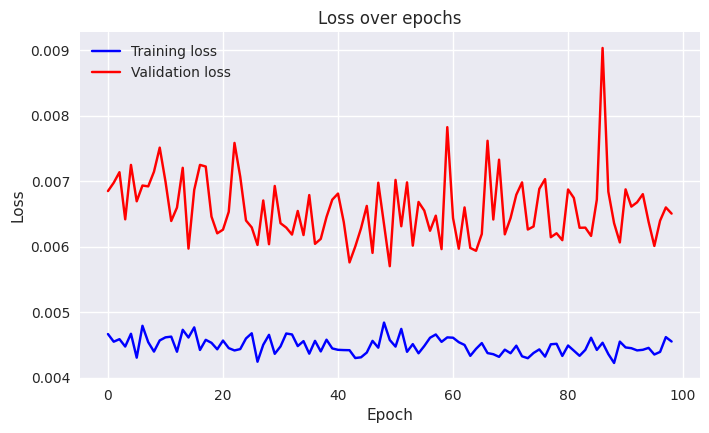

In [ ]:
model, optimizer, losses = training_loop(model, criterion, optimizer, train_loader, 
                                          valid_loader, epochs, device, 
                                          save_dir=CHECKPOINTS_PATH, 
                                          save_every=save_every, 
                                          print_every=print_every)

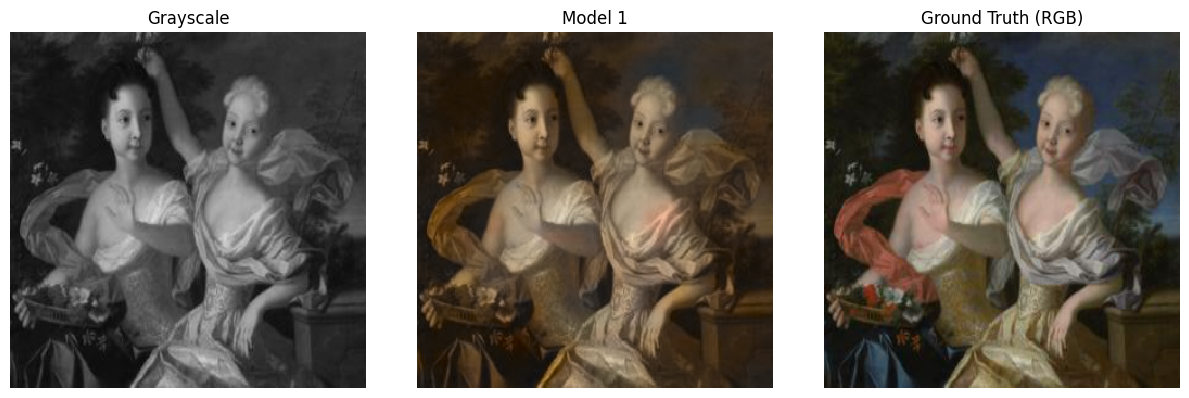

In [ ]:
show_model_results(model,
                   model_name='Model 1', 
                   lab_version=lab_version, 
                   path=get_random_file('/content/files/dataset/dataset_updated/training_set/imgT/painting', 'jpg'), 
                   img_size=328, 
                   device=device)

# ***`deep model with Adam`***

In [ ]:
model = ColorCNN_v1(lab_version=lab_version).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

07:48:25 --- Epoch: 0	Train loss: 0.0077	Valid loss: 0.0087	Epoch time: 44.89 (avg. 44.89)
07:49:09 --- Epoch: 1	Train loss: 0.0052	Valid loss: 0.0079	Epoch time: 44.22 (avg. 44.56)
07:49:53 --- Epoch: 2	Train loss: 0.0050	Valid loss: 0.0077	Epoch time: 44.03 (avg. 44.38)
07:50:38 --- Epoch: 3	Train loss: 0.0051	Valid loss: 0.0079	Epoch time: 44.34 (avg. 44.37)
07:51:22 --- Epoch: 4	Train loss: 0.0049	Valid loss: 0.0078	Epoch time: 43.93 (avg. 44.28)
07:52:06 --- Epoch: 5	Train loss: 0.0048	Valid loss: 0.0077	Epoch time: 44.23 (avg. 44.27)
07:52:50 --- Epoch: 6	Train loss: 0.0049	Valid loss: 0.0074	Epoch time: 44.21 (avg. 44.27)
07:53:34 --- Epoch: 7	Train loss: 0.0046	Valid loss: 0.0069	Epoch time: 44.28 (avg. 44.27)
07:54:19 --- Epoch: 8	Train loss: 0.0050	Valid loss: 0.0074	Epoch time: 44.48 (avg. 44.29)
07:55:05 --- Epoch: 9	Train loss: 0.0050	Valid loss: 0.0070	Epoch time: 45.80 (avg. 44.44)
07:55:52 --- Epoch: 10	Train loss: 0.0049	Valid loss: 0.0073	Epoch time: 47.47 (avg. 44.72

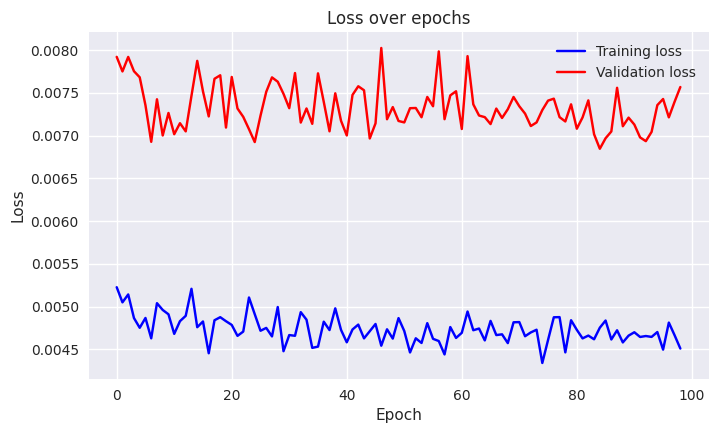

In [ ]:
model, optimizer, losses = training_loop(model, criterion, optimizer, train_loader, 
                                          valid_loader, epochs, device, 
                                          save_dir=CHECKPOINTS_PATH, 
                                          save_every=save_every, 
                                          print_every=print_every)

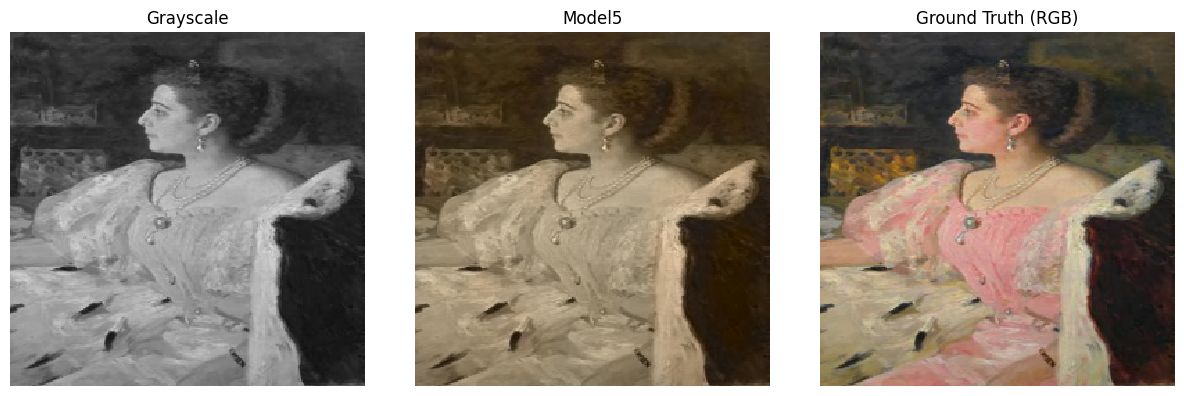

In [ ]:
show_model_results(model,
                   model_name='Model5', 
                   lab_version=lab_version, 
                   path=get_random_file('/content/files/dataset/dataset_updated/training_set/imgT/painting', 'jpg'), 
                   img_size=256, 
                   device=device)

# ***`base model with diffrent Ir`***

In [ ]:
model = ColorCNN_v0(lab_version=lab_version).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.004)


13:02:17 --- Epoch: 0	Train loss: 0.0229	Valid loss: 0.0092	Epoch time: 9.88 (avg. 9.88)
13:02:27 --- Epoch: 1	Train loss: 0.0061	Valid loss: 0.0099	Epoch time: 10.03 (avg. 9.95)
13:02:36 --- Epoch: 2	Train loss: 0.0058	Valid loss: 0.0084	Epoch time: 9.94 (avg. 9.95)
13:02:47 --- Epoch: 3	Train loss: 0.0058	Valid loss: 0.0094	Epoch time: 10.04 (avg. 9.97)
13:02:56 --- Epoch: 4	Train loss: 0.0058	Valid loss: 0.0087	Epoch time: 9.93 (avg. 9.96)
13:03:06 --- Epoch: 5	Train loss: 0.0058	Valid loss: 0.0082	Epoch time: 9.77 (avg. 9.93)
13:03:16 --- Epoch: 6	Train loss: 0.0062	Valid loss: 0.0095	Epoch time: 9.81 (avg. 9.91)
13:03:26 --- Epoch: 7	Train loss: 0.0059	Valid loss: 0.0082	Epoch time: 9.84 (avg. 9.91)
13:03:36 --- Epoch: 8	Train loss: 0.0057	Valid loss: 0.0090	Epoch time: 9.88 (avg. 9.90)
13:03:46 --- Epoch: 9	Train loss: 0.0056	Valid loss: 0.0088	Epoch time: 9.93 (avg. 9.90)
13:03:56 --- Epoch: 10	Train loss: 0.0058	Valid loss: 0.0084	Epoch time: 9.95 (avg. 9.91)
13:04:06 --- Epoch

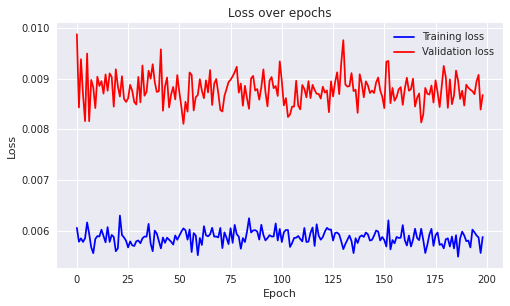

In [ ]:
model, optimizer, losses = training_loop(model, criterion, optimizer, train_loader, 
                                          valid_loader, epochs, device, 
                                          save_dir=CHECKPOINTS_PATH, 
                                          save_every=save_every, 
                                          print_every=print_every)

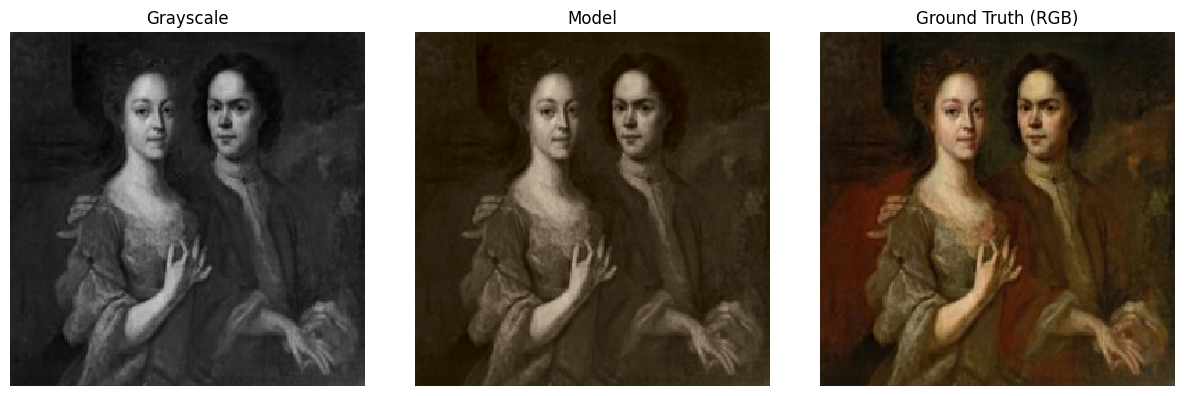

In [ ]:
show_model_results(model,
                   model_name='Model', 
                   lab_version=lab_version, 
                   path=get_random_file('/content/files/dataset/dataset_updated/training_set/imgT/painting', 'jpg'), 
                   img_size=256, 
                   device=device)

# ***`base model with Adam`***

In [ ]:
model = ColorCNN_v0(lab_version=lab_version).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

17:15:03 --- Epoch: 0	Train loss: 0.0056	Valid loss: 0.0079	Epoch time: 9.13 (avg. 9.13)
17:15:12 --- Epoch: 1	Train loss: 0.0051	Valid loss: 0.0079	Epoch time: 9.15 (avg. 9.14)
17:15:21 --- Epoch: 2	Train loss: 0.0049	Valid loss: 0.0075	Epoch time: 9.16 (avg. 9.15)
17:15:30 --- Epoch: 3	Train loss: 0.0052	Valid loss: 0.0074	Epoch time: 9.04 (avg. 9.12)
17:15:39 --- Epoch: 4	Train loss: 0.0051	Valid loss: 0.0074	Epoch time: 9.09 (avg. 9.11)
17:15:48 --- Epoch: 5	Train loss: 0.0049	Valid loss: 0.0078	Epoch time: 9.06 (avg. 9.10)
17:15:57 --- Epoch: 6	Train loss: 0.0050	Valid loss: 0.0073	Epoch time: 9.15 (avg. 9.11)
17:16:07 --- Epoch: 7	Train loss: 0.0047	Valid loss: 0.0073	Epoch time: 9.11 (avg. 9.11)
17:16:16 --- Epoch: 8	Train loss: 0.0047	Valid loss: 0.0070	Epoch time: 9.10 (avg. 9.11)
17:16:25 --- Epoch: 9	Train loss: 0.0049	Valid loss: 0.0072	Epoch time: 9.10 (avg. 9.11)
17:16:34 --- Epoch: 10	Train loss: 0.0045	Valid loss: 0.0076	Epoch time: 9.10 (avg. 9.11)
17:16:43 --- Epoch: 

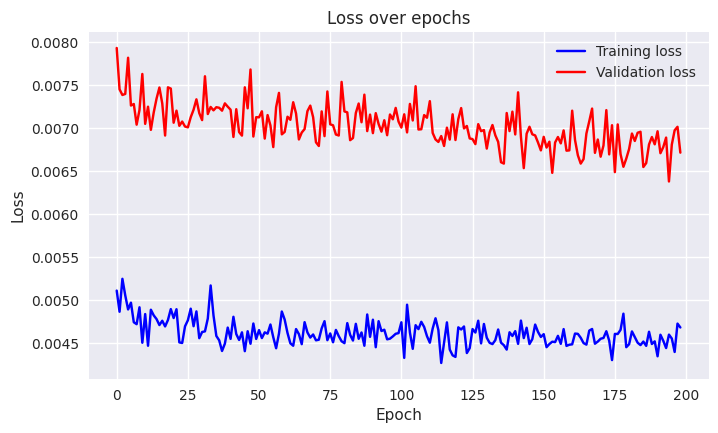

In [ ]:
model, optimizer, losses = training_loop(model, criterion, optimizer, train_loader, 
                                          valid_loader, epochs, device, 
                                          save_dir=CHECKPOINTS_PATH, 
                                          save_every=save_every, 
                                          print_every=print_every)

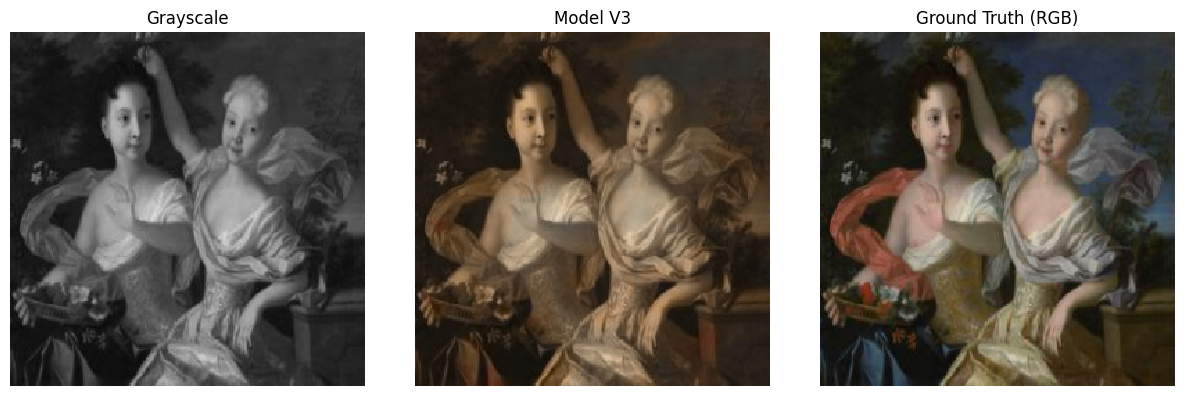

In [ ]:
show_model_results(model, 
                   model_name='Model V3', 
                   lab_version=lab_version, 
                   path=get_random_file('/content/files/dataset/dataset_updated/training_set/imgT/painting', 'jpg'), 
                   img_size=256, 
                   device=device)

# ***`base model with SGD`***

In [ ]:
model = ColorCNN_v0(lab_version=lab_version).to(device)
criterion = nn.MSELoss()
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

18:09:49 --- Epoch: 0	Train loss: 0.0121	Valid loss: 0.0182	Epoch time: 9.18 (avg. 9.18)
18:09:58 --- Epoch: 1	Train loss: 0.0115	Valid loss: 0.0171	Epoch time: 9.07 (avg. 9.13)
18:10:07 --- Epoch: 2	Train loss: 0.0103	Valid loss: 0.0161	Epoch time: 9.15 (avg. 9.13)
18:10:16 --- Epoch: 3	Train loss: 0.0100	Valid loss: 0.0153	Epoch time: 9.14 (avg. 9.13)
18:10:25 --- Epoch: 4	Train loss: 0.0095	Valid loss: 0.0145	Epoch time: 9.10 (avg. 9.13)
18:10:34 --- Epoch: 5	Train loss: 0.0086	Valid loss: 0.0139	Epoch time: 9.05 (avg. 9.12)
18:10:44 --- Epoch: 6	Train loss: 0.0084	Valid loss: 0.0133	Epoch time: 9.04 (avg. 9.11)
18:10:53 --- Epoch: 7	Train loss: 0.0078	Valid loss: 0.0129	Epoch time: 9.09 (avg. 9.10)
18:11:02 --- Epoch: 8	Train loss: 0.0079	Valid loss: 0.0124	Epoch time: 9.07 (avg. 9.10)
18:11:11 --- Epoch: 9	Train loss: 0.0075	Valid loss: 0.0120	Epoch time: 9.00 (avg. 9.09)
18:11:20 --- Epoch: 10	Train loss: 0.0073	Valid loss: 0.0117	Epoch time: 9.06 (avg. 9.09)
18:11:29 --- Epoch: 

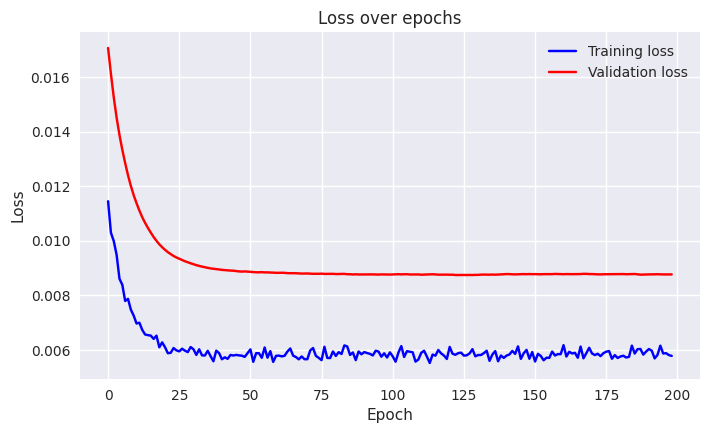

In [ ]:
model, optimizer, losses = training_loop(model, criterion, optimizer, train_loader, 
                                          valid_loader, epochs, device, 
                                          save_dir=CHECKPOINTS_PATH, 
                                          save_every=save_every, 
                                          print_every=print_every)

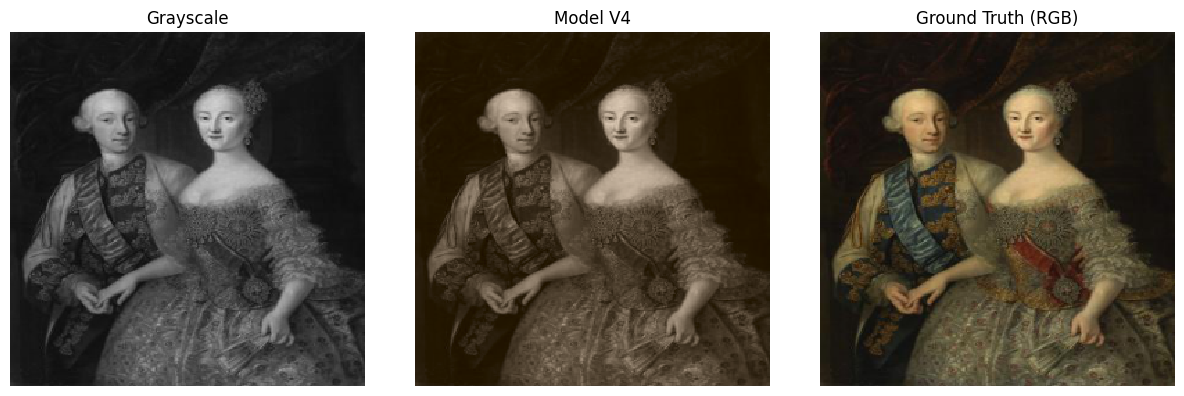

In [ ]:
show_model_results(model, 
                   model_name='Model V4', 
                   lab_version=lab_version, 
                   path=get_random_file('/content/files/dataset/dataset_updated/training_set/imgT/painting', 'jpg'), 
                   img_size=256, 
                   device=device)

# ***`autoencoder with resnet`***

In [ ]:
class ColorCNN_v2(nn.Module):
    def __init__(self, lab_version, input_size=128):
        super(ColorCNN_v2, self).__init__()
        MIDLEVEL_FEATURE_SIZE = 128
        
        if lab_version == 1:
            self.final = nn.Tanh()
        elif lab_version == 2:
            self.final = nn.ReLU()
            
        ## ResNet
        resnet = models.resnet18(num_classes=365) 
        # Change first conv layer to accept single-channel (grayscale) input
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
        # Extract midlevel features from ResNet-gray
        self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])
        
        self.upsampling = Upsample(scale_factor=2, mode='nearest')

        ## Upsampling and colorization
        self.upsample = nn.Sequential(     
            nn.Conv2d(in_channels=MIDLEVEL_FEATURE_SIZE,
                      out_channels=128, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            self.upsampling,
            nn.Conv2d(in_channels=128, out_channels=64,
                      kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            self.upsampling,
            nn.Conv2d(in_channels=64, out_channels=32,
                      kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(32),
            self.final,
            nn.Conv2d(in_channels=32, out_channels=2,
                      kernel_size=(3, 3), stride=1, padding=1),
            self.upsampling
        )

    def forward(self, input):

        # ResNet - feature extraction
        midlevel_features = self.midlevel_resnet(input)

        # Upsampling and colorization
        output = self.upsample(midlevel_features)
        return output

In [ ]:
model = ColorCNN_v2(lab_version=lab_version).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model

ColorCNN_v2(
  (final): Tanh()
  (midlevel_resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [ ]:
model, optimizer, losses = training_loop(model, criterion, optimizer, train_loader, 
                                          valid_loader, epochs, device, 
                                          save_dir=CHECKPOINTS_PATH, 
                                          save_every=save_every, 
                                          print_every=print_every)

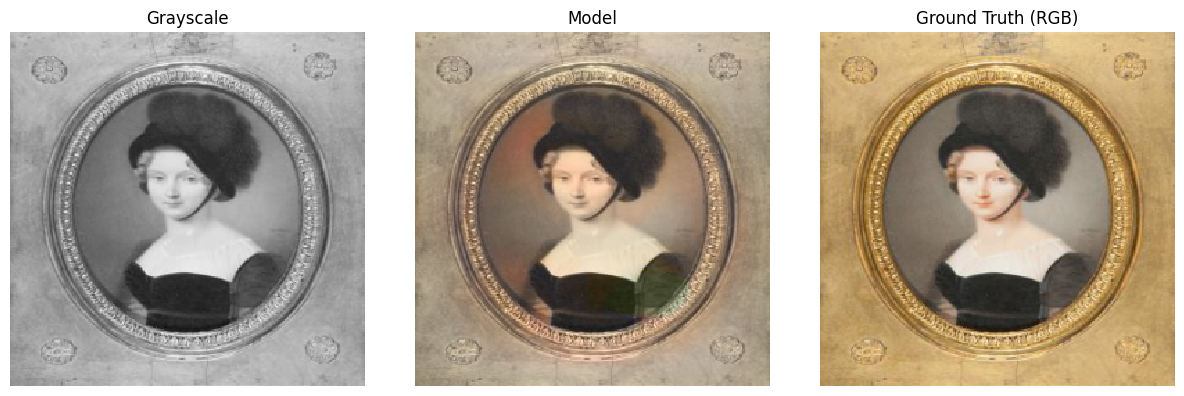

In [ ]:
show_model_results(model, 
                   model_name='Model', 
                   lab_version=lab_version, 
                   path=get_random_file('/content/files/dataset/dataset_updated/training_set/imgT/painting', 'jpg'), 
                   img_size=256, 
                   device=device)

# ***`base model with MAE loss`***

In [34]:
model = ColorCNN_v0(lab_version=lab_version).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

14:21:33 --- Epoch: 0	Train loss: 0.0675	Valid loss: 0.0665	Epoch time: 9.33 (avg. 9.33)
14:21:42 --- Epoch: 1	Train loss: 0.0487	Valid loss: 0.0635	Epoch time: 9.18 (avg. 9.26)
14:21:51 --- Epoch: 2	Train loss: 0.0485	Valid loss: 0.0640	Epoch time: 9.01 (avg. 9.17)
14:22:00 --- Epoch: 3	Train loss: 0.0481	Valid loss: 0.0644	Epoch time: 8.96 (avg. 9.12)
14:22:09 --- Epoch: 4	Train loss: 0.0472	Valid loss: 0.0618	Epoch time: 8.91 (avg. 9.08)
14:22:18 --- Epoch: 5	Train loss: 0.0467	Valid loss: 0.0695	Epoch time: 9.05 (avg. 9.08)
14:22:27 --- Epoch: 6	Train loss: 0.0461	Valid loss: 0.0636	Epoch time: 8.90 (avg. 9.05)
14:22:36 --- Epoch: 7	Train loss: 0.0470	Valid loss: 0.0637	Epoch time: 8.99 (avg. 9.04)
14:22:45 --- Epoch: 8	Train loss: 0.0474	Valid loss: 0.0630	Epoch time: 8.86 (avg. 9.02)
14:22:54 --- Epoch: 9	Train loss: 0.0457	Valid loss: 0.0647	Epoch time: 8.98 (avg. 9.02)
14:23:03 --- Epoch: 10	Train loss: 0.0455	Valid loss: 0.0620	Epoch time: 8.93 (avg. 9.01)
14:23:11 --- Epoch: 

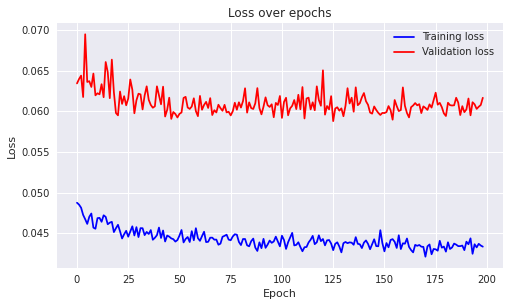

In [35]:
model, optimizer, losses = training_loop(model, criterion, optimizer, train_loader, 
                                          valid_loader, epochs, device, 
                                          save_dir=CHECKPOINTS_PATH, 
                                          save_every=save_every, 
                                          print_every=print_every)

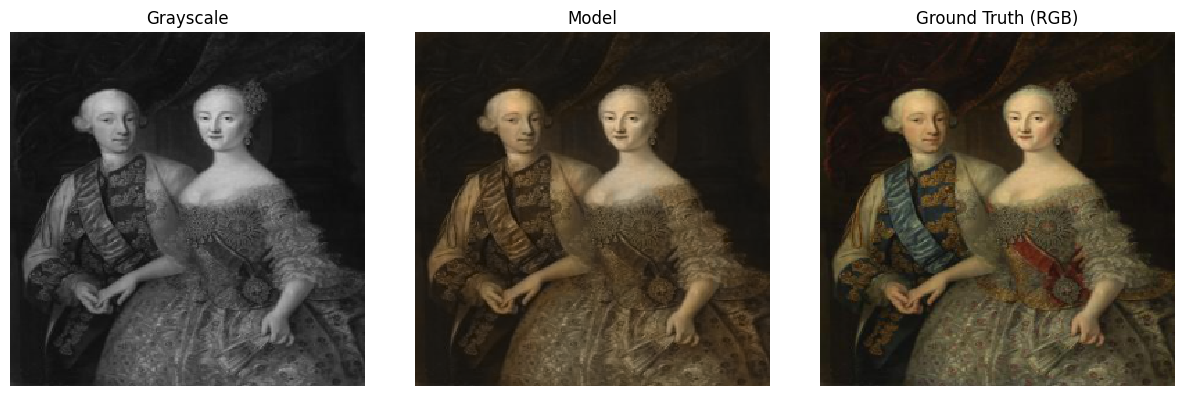

In [48]:
show_model_results(model, 
                   model_name='Model', 
                   lab_version=lab_version, 
                   path=get_random_file('/content/files/dataset/dataset_updated/training_set/imgT/painting', 'jpg'), 
                   img_size=256, 
                   device=device)

# ***`deep model with MAE loss`***

In [59]:
model = ColorCNN_v1(lab_version=lab_version).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

15:30:57 --- Epoch: 0	Train loss: 0.0600	Valid loss: 0.0724	Epoch time: 34.57 (avg. 34.57)
15:31:31 --- Epoch: 1	Train loss: 0.0505	Valid loss: 0.0644	Epoch time: 34.10 (avg. 34.34)
15:32:06 --- Epoch: 2	Train loss: 0.0482	Valid loss: 0.0646	Epoch time: 34.39 (avg. 34.35)
15:32:39 --- Epoch: 3	Train loss: 0.0467	Valid loss: 0.0625	Epoch time: 33.45 (avg. 34.13)
15:33:13 --- Epoch: 4	Train loss: 0.0479	Valid loss: 0.0639	Epoch time: 34.00 (avg. 34.10)
15:33:47 --- Epoch: 5	Train loss: 0.0478	Valid loss: 0.0640	Epoch time: 34.03 (avg. 34.09)
15:34:21 --- Epoch: 6	Train loss: 0.0477	Valid loss: 0.0621	Epoch time: 33.37 (avg. 33.99)
15:34:54 --- Epoch: 7	Train loss: 0.0469	Valid loss: 0.0628	Epoch time: 33.35 (avg. 33.91)
15:35:27 --- Epoch: 8	Train loss: 0.0456	Valid loss: 0.0639	Epoch time: 33.57 (avg. 33.87)
15:36:02 --- Epoch: 9	Train loss: 0.0461	Valid loss: 0.0636	Epoch time: 34.91 (avg. 33.97)
15:36:39 --- Epoch: 10	Train loss: 0.0452	Valid loss: 0.0621	Epoch time: 36.98 (avg. 34.25

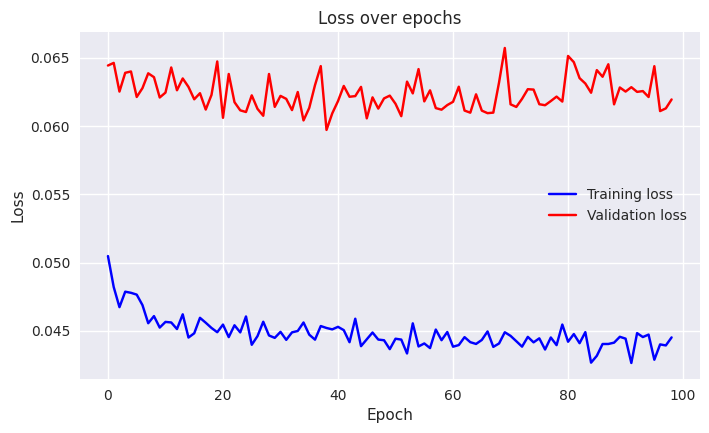

In [60]:
model, optimizer, losses = training_loop(model, criterion, optimizer, train_loader, 
                                          valid_loader, epochs, device, 
                                          save_dir=CHECKPOINTS_PATH, 
                                          save_every=save_every, 
                                          print_every=print_every)

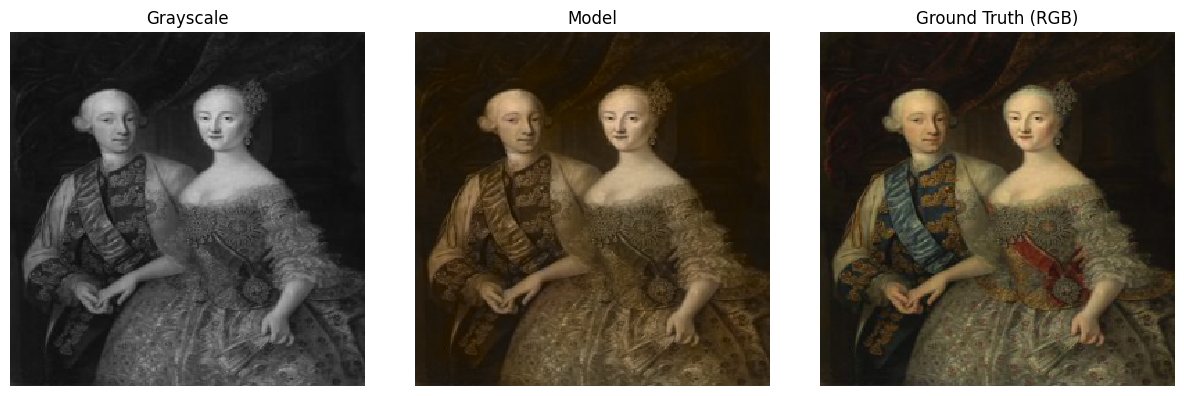

In [83]:
show_model_results(model,
                   model_name='Model', 
                   lab_version=lab_version, 
                   path=get_random_file('/content/files/dataset/dataset_updated/training_set/imgT/painting', 'jpg'), 
                   img_size=256, 
                   device=device)

# ***`classes & functions`***

In [20]:
#Used for storing the metrics over epochs.

class AverageMeter(object):
    
    def __init__(self):
        self.reset()
    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        

In [19]:
# A class used for non-learnable upsampling of the images.

class Upsample(nn.Module):

    def __init__(self, scale_factor=2, mode='nearest'):
        super(Upsample, self).__init__()
        self.interp = nn.functional.interpolate
        self.scale_factor = scale_factor
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale_factor, mode=self.mode)
        return x

In [18]:
#Show/save rgb image from grayscale and ab channels
def save_temp_results(gray_input, ab_input, lab_version, save_path=None, save_name=None):
    
    plt.clf() # clear matplotlib 
    
    gray_output, color_output = combine_channels(gray_input, ab_input, lab_version)
    
    if save_path is not None and save_name is not None: 
        plt.imsave(arr=gray_output, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
        plt.imsave(arr=color_output, fname='{}{}'.format(save_path['colorized'], save_name))
        
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    for i, (input_gray, input_ab, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        input_gray = input_gray.to(device)
        input_ab = input_ab.to(device)
    
        # Forward pass
        output_ab = model(input_gray) 
        loss = criterion(output_ab, input_ab) 
        running_loss += loss.item() * input_gray.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, save_images, gray_path, color_path, device, epoch, lab_version):
    model.eval()
    running_loss = 0
    already_saved_images = False
    
    for i, (input_gray, input_ab, target) in enumerate(valid_loader):
    
        input_gray = input_gray.to(device)
        input_ab = input_ab.to(device)

        # Forward pass and record loss
        output_ab = model(input_gray)
        loss = criterion(output_ab, input_ab)
        running_loss += loss.item() * input_gray.size(0)

        # Save images to file
        if save_images and not already_saved_images:
            already_saved_images = True
            for j in range(min(len(output_ab), 2)): # save at most 2 images
                save_path = {'grayscale': gray_path, 
                             'colorized': color_path}
                save_name = f'img-{i * valid_loader.batch_size + j}-epoch-{epoch}.jpg'
                save_temp_results(input_gray[j], 
                                  ab_input=output_ab[j].detach(), 
                                  lab_version=lab_version,
                                  save_path=save_path, 
                                  save_name=save_name)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def validate_short(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0
    
    for i, (input_gray, input_ab, target) in enumerate(valid_loader):
    
        input_gray = input_gray.to(device)
        input_ab = input_ab.to(device)

        # Forward pass and record loss
        output_ab = model(input_gray)
        loss = criterion(output_ab, input_ab)
        running_loss += loss.item() * input_gray.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, save_dir, save_every, print_every):

    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    time_meter = AverageMeter()

    # Train model
    for epoch in range(0, epochs):

        start_time = time.time()

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate_short(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        checkpoint = {
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'train_losses': train_losses,
                'valid_losses': valid_losses
        }

        if epoch % save_every == (save_every - 1):
            save_checkpoint(checkpoint, filename=f'checkpoint_epoch_{epoch}.pth.tar', path=save_dir)

        # Save checkpoint and replace old best model if current model is better
        if valid_loss < best_loss:
            best_loss = valid_loss
            save_checkpoint(checkpoint, is_best=True, path=save_dir)

        end_time = time.time()
        epoch_time = end_time - start_time
        time_meter.update(epoch_time)

        if epoch % print_every == (print_every - 1):
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Epoch time: {epoch_time:.2f} (avg. {time_meter.avg:.2f})')

    plot_losses(train_losses[1:], valid_losses[1:])
    
    return model, optimizer, (train_losses, valid_losses)

In [17]:
#Helper function for plotting losses over epochs.
def plot_losses(train_losses, valid_losses):
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')


#Function for saving the checkpoint of a PyTorch NN.
def save_checkpoint(state, is_best=False, filename=None, path=None):
    
    if path:
        if not os.path.isdir(path):
            os.makedirs(path)
    else:
        path = ''
        
    if filename:
        filename = os.path.join(path, filename)
        torch.save(state, filename)

    if is_best:
        best_path = os.path.join(path, 'model_best.pth.tar')
        torch.save(state, best_path)
        
class Upsample(nn.Module):
    
    def __init__(self, scale_factor=2, mode='nearest'):
        super(Upsample, self).__init__()
        self.interp = nn.functional.interpolate
        self.scale_factor = scale_factor
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale_factor, mode=self.mode)
        return x
        
def show_model_results(model, model_name, lab_version, path, img_size, device):
    
    assert device in ['cpu', 'cuda'], 'Invalid device!'

    test_image = imread(path)
    test_image = resize(test_image, (img_size, img_size))
    test_image_gray = rgb2gray(test_image)
    
    gray_tensor = torch.from_numpy(test_image_gray).unsqueeze(0).unsqueeze(0).float().to(device)
    
    with torch.no_grad():
        ab_tensor = model(gray_tensor)
        
    _, color_output = combine_channels(gray_tensor[0], ab_tensor[0], lab_version)
        
    fig, ax = plt.subplots(1, 3, figsize = (12, 15))

    imshow(test_image_gray, ax=ax[0])
    ax[0].axis('off')
    ax[0].set_title('Grayscale')
    
    imshow(color_output, ax=ax[1])
    ax[1].axis('off')
    ax[1].set_title(model_name)
    
    imshow(test_image, ax=ax[2]) 
    ax[2].axis('off')
    ax[2].set_title('Ground Truth (RGB)')

    fig.show()



In [16]:
class ColorizationImageFolder(datasets.ImageFolder):
    '''
    Custom ImageFolder, which additionally converts original RGB images to 
    Lab. 
    Two lab versions are allowed:
    * 1 - the output of the a/b channels is in the range of [-1,1]
    * 2 - the output of the a/b channels is in the range of [0,1]
    '''
    
    def __init__(self, lab_version, **kw):
        self.lab_version=lab_version
        super(ColorizationImageFolder, self).__init__(**kw)
                
    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)
        
        if self.transform is not None:
            img_original = self.transform(img)
            img_original = np.asarray(img_original)
            
            if self.lab_version == 1:
                # output is in range [1,1] -> tanh activation
                img_lab = rgb2lab(img_original / 255.0)
                img_lab = (img_lab + [0, 0, 0]) / [100, 128, 128] 
            elif self.lab_version == 2:
                # output is in range [0,1]
                img_lab = rgb2lab(img_original)
                img_lab = (img_lab + [0, 128, 128]) / [100, 255, 255]
            else:
                raise ValueError('Incorrect Lab version!!!')
                
            img_ab = img_lab[:,:,1:3]
            img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
            
            img_gray = img_lab[:,:,0]
            img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()
                    
        if self.target_transform is not None:
            target = self.target_transform(target)
        
        return img_gray, img_ab, target

In [15]:
def get_random_file(from_dir, file_format):
    
    assert os.path.isdir(from_dir), 'Source directory does not exist!'
    
    file_list = glob.glob(f'{from_dir}/*.{file_format}')
    return random.choice(file_list)

In [14]:
def combine_channels(gray_input, ab_input, lab_version):
    
    if gray_input.is_cuda: gray_input = gray_input.cpu()
    if ab_input.is_cuda: ab_input = ab_input.cpu()
    
    # combine channels
    color_image = torch.cat((gray_input, ab_input), 0).numpy()
    color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
    
    # reverse the transformation from DataLoaders
    if lab_version == 1:
        color_image = color_image * [100, 128, 128]
    elif lab_version == 2:
        color_image = color_image * [100, 255, 255] - [0, 128, 128]
    else:
        raise ValueError('Incorrect Lab version!!!')
    
    # prepare the grayscale/RGB imagers
    gray_output = gray_input.squeeze().numpy()
    color_output = lab2rgb(color_image.astype(np.float64))
    
    return gray_output, color_output